# TPU Fundamentals

This codelab will walk you through the creation of a simple model using the TF-TPU programming primitives.  We also demonstrate how to use the TPUEstimator and Keras APIs to simplify common training tasks.

For most models, we recommend using the high-level APIs, but understanding the underlying TPU programming model is important for debugging or for advanced/custom training scenarios.

In [0]:
import numpy as np
import six
import tensorflow as tf
import time
import os

TPU_ZONE = "us-central1-c" #@param {type: "string"}
WORKER_NAME = "tpu-8" #@param {type:"string"}

TPU_WORKER = tf.contrib.cluster_resolver.TPUClusterResolver(
    zone=TPU_ZONE,
    tpu=WORKER_NAME
).get_master()

session = tf.Session(TPU_WORKER)
session.list_devices()

[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 9336221880897508273),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9702753475298910928),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 2543395752018289318),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13322103454321532478),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16678475719678247740),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7922025826824989191),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9679152681033432777),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16321885994226675577),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 3277014100976687712),
 _DeviceAttributes(/job:tpu_worker/r

## What makes TPU modeling special?

Writing TensorFlow models for the TPU differs from the CPU and GPU modeling you may be familiar with in a few important ways:

Model functions are just-in-time compiled to run on the device.
Almost all models are replicated by default, using synchronous in-graph replication (go/tf-strong-sync).
An early goal of the TPU program was the ability to scale up. Individual TPU cores are powerful (~70 TFlops per core in the DragonFish generation), but the specialized network and hardware transfer support truly distinguish TPUs from other devices. The interconnect between TPU chips is an order of magnitude faster and lower-latency than the normal datacenter network fabric. This allows us to build models that scale up transparently using batch parallelism and synchronous replication.

The TF-TPU programming model is designed to help your TF model take advantage of this scaling ability. Some models can scale to the size of an entire TPU pod (2048 cores!). To utilize TPUs effectively we need to make a few changes to how we develop our models, which we'll cover below.

## tpu.rewrite and model functions

We refer to the portion of a TF model that runs on the TPU as a "model function". Most programs have a single model function which computes the training step for your model. Explicitly encapsulating the TPU related logic in a model function allows the TPU software stack to compile your model and implicitly replicate it across multiple TPU cores in a cluster. Let's start with a simple model function that adds two tensors.

In [0]:
def add(x, y):
  return x + y

This model takes 2 arguments and adds them together. Obviously this isn't a terribly interesting use of a TPU but we can run this model on the TPU nevertheless! We first need to wrap our model with a call to tpu.rewrite:

In [0]:
x = tf.placeholder(name='x', dtype=tf.float32)
y = tf.placeholder(name='y', dtype=tf.float32)
tpu_add = tf.contrib.tpu.rewrite(add, [x, y])

What's happening here? The tpu.rewrite call returns a version of our original function which is ready to be executed on the TPU. Now we can run it on our device!

Note the initialize_system call. These are necessary to reset the TPU hardware. In the future, this initialization should occur automatically, but for now remember that you'll need to call them to initialize your session.

In [0]:
session.run(tf.contrib.tpu.initialize_system())

'\n\x03\x02\x02\x02\x10\x01\x18\x08"\x18\x00\x00\x00\x00\x00\x01\x00\x01\x00\x00\x01\x01\x01\x00\x00\x01\x00\x01\x01\x01\x00\x01\x01\x01'

In [0]:
z = session.run(tpu_add, {x: np.arange(16), y: np.ones(16)})
print('Result of TPU computation: %s', z)

('Result of TPU computation: %s', [array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.], dtype=float32)])


## Running Logistic Regression

Our first example wasn't very exciting. After all, we're interested in using the TPU to train models, not add tensors together. Let's change our model to learn a simple classifier via logistic regression.

We'll use the well known MNIST dataset (easily imported via tf.keras.datasets), and to keep things as simple as possible, we will use a single fully connected layer to make our predictions.

In [0]:
IMAGE_SIZE = 28 * 28
NUM_LABELS = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [0]:
def fit_batch(img, labels):
  with tf.variable_scope('tpu', reuse=tf.AUTO_REUSE):
    # flatten images
    x = tf.reshape(img, [-1, IMAGE_SIZE])
    
    W = tf.get_variable('W', [28*28, 10])  # pylint: disable=invalid-name
    b = tf.get_variable('b', [10], initializer=tf.zeros_initializer)
    logits = tf.matmul(x, W) + b
    print(img, logits, labels)
    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
    optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)

    return loss, optimizer.minimize(loss, tf.train.get_or_create_global_step())

The only unusual part of our model above the use of `CrossShardOptimizer`: this wraps a standard TF optimizer and allows us to train on multiple cores simultaneously (we'll demonstrate that below).

And now we can train our model!  Note we use `tpu.rewrite` again to create a TPU version of our computation.  We'll only use the first 1000 images from our training data for this example.

In [0]:
images = tf.placeholder(name='images', dtype=tf.float32, shape=[None, 28, 28])
labels = tf.placeholder(name='labels', dtype=tf.int32, shape=[None,])

fit_on_tpu = tf.contrib.tpu.rewrite(fit_batch, [images, labels])

session.run(tf.global_variables_initializer())
for i in range(50):
  loss = session.run(fit_on_tpu, {
      images: x_train[:1000], labels: y_train[:1000]
  })
  if i % 10 == 0:
    print('loss = %s' % loss)

(<tf.Tensor 'replicated_input_0_1:0' shape=(?, 28, 28) dtype=float32>, <tf.Tensor 'tpu/add:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'replicated_input_1_1:0' shape=(?,) dtype=int32>)
loss = [157.5869]
loss = [603.5714]
loss = [221.9446]
loss = [84.47755]
loss = [39.039734]


Now we can sample predictions from our test set to see how well we're doing:

In [0]:
def predict(img):
  with tf.variable_scope('tpu', reuse=tf.AUTO_REUSE):
    # flatten images
    x = tf.reshape(img, [-1, IMAGE_SIZE])
    
    W = tf.get_variable('W', [28*28, 10])  # pylint: disable=invalid-name
    b = tf.get_variable('b', [10], initializer=tf.zeros_initializer)
    logits = tf.matmul(x, W) + b
    return tf.nn.softmax(logits)

predict_on_tpu = tf.contrib.tpu.rewrite(predict, [images,])

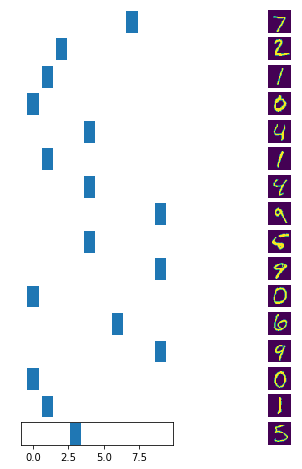

In [0]:
from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  f, axes = pyplot.subplots(16, 2)
  for i in range(16):
    axes[i, 0].bar(np.arange(10), predictions[i])
    axes[i, 1].imshow(images[i])
    axes[i, 1].axis('off')

    if i != 15:
      axes[i, 0].axis('off')
    else:
      axes[i, 0].get_yaxis().set_visible(False)
  pyplot.gcf().set_size_inches(6, 8)  


[predictions] = session.run(predict_on_tpu, {
    images: x_test[:16],
})
plot_predictions(x_test[:16], predictions)

We can see our network has quickly converged towards mostly correct observations!

## Using Multiple TPU Cores with Batch Parallelism

Up until this point our models have only been running on a single TPU core.  This is wasting a lot of the power of TPUs!

Let's change that so we can take advantage of our entire TPU device (8 cores). Scaling up to multiple cores with TPUs uses a different mechanism than the asynchronous out of graph replication used in CPU deployments. With TPUs, the software stack handles the replication for you: this is important to keep in mind, as you must use the builtin TPU replication to take advantage of the specialized TPU network. Fortunately TPU replication is easy to use. 

We just replace `tpu.rewrite` with `tpu.batch_parallel`: the TPU system handles the rest!  We just need to make sure our batches are divisible by the number of cores (8).

In [0]:
fit_multi_on_tpu = tf.contrib.tpu.batch_parallel(fit_batch, [images, labels], num_shards=8)

session.run(tf.global_variables_initializer())
for i in range(50):
  loss = session.run(fit_multi_on_tpu, {
      images: x_train[:1024], labels: y_train[:1024]
  })
  if i % 10 == 0:
    print('loss = %f %s' % (np.mean(loss), loss))

(<tf.Tensor 'replicated_input_0_8:0' shape=(?, 28, 28) dtype=float32>, <tf.Tensor 'tpu_7/add:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'replicated_input_1_7:0' shape=(?,) dtype=int32>)
loss = 184.585709 [array([164.58215, 177.97446, 177.83514, 187.68109, 200.10535, 188.58192,
       200.66034, 179.26518], dtype=float32)]
loss = 400.529968 [array([410.69553, 393.01617, 390.59814, 303.62778, 401.64682, 486.13953,
       450.43735, 368.07822], dtype=float32)]
loss = 215.500458 [array([177.71259, 164.83682, 235.23889, 155.6958 , 201.73482, 178.76172,
       262.34232, 347.6806 ], dtype=float32)]
loss = 80.522781 [array([113.04523 ,  28.655207,  86.96802 ,  88.72688 ,  58.281162,
        47.917015, 124.70637 ,  95.88239 ], dtype=float32)]
loss = 37.783630 [array([56.398525,  2.276804, 46.69822 , 29.78248 ,  3.913189, 28.39028 ,
       81.50957 , 53.299973], dtype=float32)]


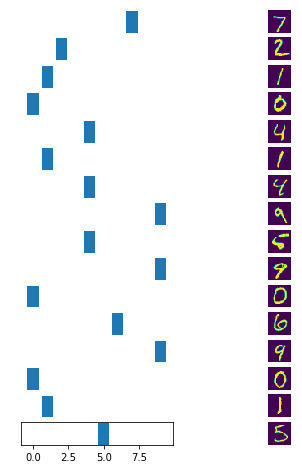

In [0]:
[predictions] = session.run(predict_on_tpu, {
    images: x_test[:16], labels: y_train[:16]
})

plot_predictions(x_test[:16], predictions)

If you're paying close attention to the output on this run, you may notice that our print statement for loss is now reporting 8 values instead of a single scalar! tpu.batch_parallel concatenates the output from each core to return a result. We are thus seeing the loss computed by each individual TPU core. Our CrossShardOptimizer takes care of averaging our gradients, but we must average the loss on the CPU if we want to obtain a single scalar value:

## Using Infeed and Outfeed

In our previous examples, our TPU execution looked something like this:

![alt text](https://screenshot.googleplex.com/j4PwT4FtE2n.png)

Between each call to fit the TPU device is idle waiting for the CPU. If we could queue inputs and outputs, the TPU could work on new data while the CPU is working. Depending on our model, we may be able to entirely decouple the CPU and TPU training: the CPU feeds data and pulls out loss values, and the TPU runs the training independently as long as data is available:

![queue based TPU execution](https://screenshot.googleplex.com/Oae4fq6kVm7.png)

In [0]:
BATCH_SIZE = 1024

def fit_batch_with_infeed():
  """Train one batch, reading from infeed and writing to outfeed."""
  
  # each core will read 1/8 of the total batch size
  images, labels = tf.contrib.tpu.infeed_dequeue_tuple(
      dtypes=[tf.float32, tf.int32],
      shapes=[(BATCH_SIZE // 8, 28, 28,), (BATCH_SIZE // 8,)],
      name='infeed_dequeue')
  loss, train_op = fit_batch(images, labels)
  return tf.contrib.tpu.outfeed_enqueue_tuple((loss,)), train_op

Note we can still re-use our original training function!  We've just wrapped it in the logic to remove batches from the infeed and push our loss onto the outfeed.  We return both the minimize operation and the enqueue operation from our model function to ensure that both are run as part of the TPU program.

Now let's look at the CPU side. Note that we need an enqueue/dequeue operation for each TPU core. We use the standard tf.device scope to assign our operations to a given core:

In [0]:
from tensorflow.contrib.tpu.ops.gen_tpu_ops import outfeed_dequeue_tuple

def setup_feed(image_batch, label_batch):
  """Generate TF operations for CPU side infeed and outfeed."""
  infeed_ops = []
  outfeed_ops = []
  
  # Split our input into 8 pieces and infeed each sub-batch  
  infeed_batches = zip(tf.split(image_batch, 8), tf.split(label_batch, 8))
  
  for i in range(8):
    infeed_op = infeed_enqueue_tuple(
      infeed_batches[i],
      [b.shape for b in infeed_batches[i]],
      device_ordinal=i
    )
    infeed_ops.append(infeed_op)
    
    outfeed_op = outfeed_dequeue_tuple(
        dtypes=[tf.float32], shapes=[[]], device_ordinal=i)
    outfeed_ops.append(outfeed_op)

  return [infeed_ops, outfeed_ops]

setup_feed(tf.placeholder(tf.float32, [1024, 28*28]),
           tf.placeholder(tf.int32, [1024]))

[[<tf.Operation 'InfeedEnqueueTuple_32' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_33' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_34' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_35' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_36' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_37' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_38' type=InfeedEnqueueTuple>,
  <tf.Operation 'InfeedEnqueueTuple_39' type=InfeedEnqueueTuple>],
 [[<tf.Tensor 'OutfeedDequeueTuple_32:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_33:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_34:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_35:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_36:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_37:0' shape=() dtype=float32>],
  [<tf.Tensor 'OutfeedDequeueTuple_38:0' shape=() dtype=float32>],
  

(<tf.Tensor 'infeed_dequeue_5:0' shape=(128, 28, 28) dtype=float32>, <tf.Tensor 'tpu_14/add:0' shape=(128, 10) dtype=float32>, <tf.Tensor 'infeed_dequeue_5:1' shape=(128,) dtype=int32>)
priming infeed
loss = 171.486633
loss = 387.451782
loss = 130.065475
loss = 67.700607
loss = 29.368273
final loss = 12.091688


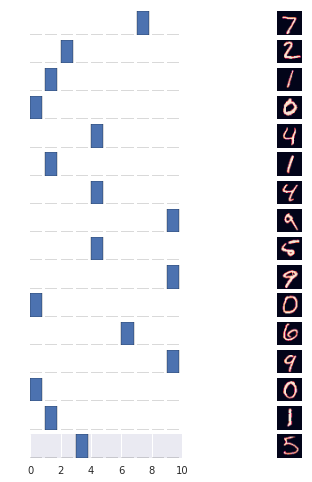

In [0]:
# Replicate our model function onto 8 cores (with no inputs)
fit_with_infeed = tf.contrib.tpu.batch_parallel(
    fit_batch_with_infeed, num_shards=8)


# Infeed requires a static shape for inputs.  We create a new set of placeholders
# here with a fixed batch size.
image_batch = tf.placeholder(name='images', dtype=tf.float32, shape=[BATCH_SIZE, 28, 28])
label_batch = tf.placeholder(name='labels', dtype=tf.int32, shape=[BATCH_SIZE,])

session.run(tf.global_variables_initializer())
infeed_ops, outfeed_ops = setup_feed(image_batch, label_batch)

# # Start training.  We first push a batch of data on the infeed so the device
# # is working while we're getting the next batch ready.
print('priming infeed')
session.run(tf.group(infeed_ops), {image_batch: x_train[:BATCH_SIZE], 
                                   label_batch: y_train[:BATCH_SIZE]})

for i in range(50):
  _, _, loss = session.run(
      [tf.group(infeed_ops), fit_with_infeed, tf.tuple(outfeed_ops)], 
      {image_batch: x_train[:BATCH_SIZE], 
       label_batch: y_train[:BATCH_SIZE]}
  )
  if i % 10 == 0:
    print('loss = %f' % np.mean(loss))

_, final_loss = session.run([fit_with_infeed, tf.tuple(outfeed_ops)])
print('final loss = %f' % np.mean(final_loss))

[predictions] = session.run(predict_on_tpu, {
    images: x_test[:16], labels: y_train[:16]
})

plot_predictions(x_test[:16], predictions)

## Training Loops

In our previous example, we used infeed and outfeed to decouple the CPU and TPU operations, but our TPU is still dependent on the CPU to "pump" the fit operation once per training loop. What if we could put a loop around the entire TPU computation such that it was entirely decoupled from the CPU? The tpu.repeat function helps us do just that. We supply a function to run in the loop and the number of times we want to run:



(<tf.Tensor 'infeed_dequeue_6:0' shape=(128, 28, 28) dtype=float32>, <tf.Tensor 'tpu_15/add:0' shape=(128, 10) dtype=float32>, <tf.Tensor 'infeed_dequeue_6:1' shape=(128,) dtype=int32>)
Infeed 0
Infeed 10
Outfeed: 0 [[149.57478], [135.07709], [162.02904], [131.66071], [139.29907], [153.06036], [156.54097], [153.29695]]
Infeed 20
Outfeed: 10 [[156.70634], [182.38503], [153.33058], [113.81522], [107.47374], [135.15005], [195.01627], [112.37045]]
Outfeed: 20 [[131.54794], [128.17017], [95.205742], [71.526894], [72.968689], [34.492043], [156.74376], [56.429298]]
Infeed 30
Outfeed: 30 [[25.600853], [11.644323], [63.159252], [70.726593], [24.404179], [39.497215], [114.56596], [56.847618]]
Infeed 40
Outfeed: 40 [[5.621439], [6.756649], [15.815907], [2.9351273], [1.4544363], [0.21570043], [53.837818], [0.022112081]]
Infeed 50
Outfeed: 50 [[0.0], [0.52061653], [1.6118298], [0.34652206], [0.0], [0.0], [20.846514], [0.19084549]]
Infeed 60
Outfeed: 60 [[0.0], [0.0], [9.3143626e-09], [0.0], [0.0002

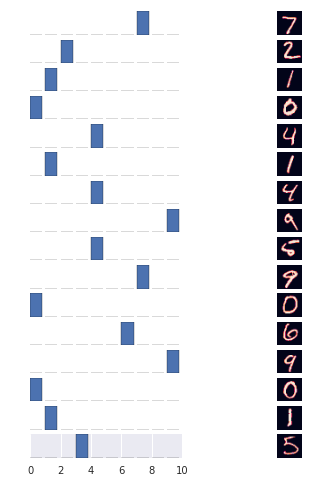

In [0]:
NUM_STEPS = 100
import threading

def fit_loop():
  return tf.contrib.tpu.repeat(NUM_STEPS, fit_batch_with_infeed)


def _run_infeed(session, infeed_ops, x, y, images, labels):
  for i in range(NUM_STEPS):
    if i % 10 == 0:
      print('Infeed %s' % i)
    session.run(infeed_ops, {x: images, y: labels})

losses = []
def _run_outfeed(session, outfeed_ops):
  # hack: store output in losses
  for i in range(NUM_STEPS):
    losses.append(session.run(outfeed_ops))
    if i % 10 == 0:
      print('Outfeed: %s %s' % (i, losses[-1]))
      
infeed_thread = threading.Thread(
    target=lambda: _run_infeed(session, infeed_ops, 
                               image_batch, label_batch,
                               x_train[:BATCH_SIZE], y_train[:BATCH_SIZE]))
outfeed_thread = threading.Thread(
    target=lambda: _run_outfeed(session, outfeed_ops))

fit_with_infeed_loop = tf.contrib.tpu.batch_parallel(fit_loop, num_shards=8)

session.run(tf.global_variables_initializer())

infeed_thread.start()
outfeed_thread.start()
session.run(fit_with_infeed_loop)
infeed_thread.join()
outfeed_thread.join()

[predictions] = session.run(predict_on_tpu, {
    images: x_test[:16], labels: y_train[:16]
})

plot_predictions(x_test[:16], predictions)

Copyright 2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License